In [1]:
from pyiron_workflow import Workflow
from structure_nodes import get_structure
from thermo_potential import obtain_potential
import numpy as np
from calphy_nodes import CreateInputDict, Initialize, RunCalculation, GetResults, InputClass

### Create input template

In [2]:
inp = InputClass(temperature=[1000, 1200],
                pressure=0,
                reference_phase = 'solid',
                mode = 'ts',
                equilibration_control = 'berendsen',
                )
inp.queue.cores = 4	

### Workflow

In [3]:
wf = Workflow('test')
wf.step1 = obtain_potential('2004--Zhou-X-W--Cu-Ag-Au--LAMMPS--ipr2')
wf.step2 = get_structure(species='Cu', repeat=(2,2,2))
wf.step3 = Initialize(inp, wf.step2.outputs.structure,
                     wf.step1.outputs.element_list,
                     wf.step1.outputs.files,
                     wf.step1.outputs.config)
wf.step4 = RunCalculation(wf.step3.outputs.calculation,
                         wf.step3.outputs.simfolder)
wf.step5 = GetResults(wf.step4.outputs.job)

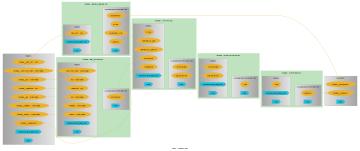

In [4]:
wf.draw(size=(5,5))

In [5]:
wf.run()

/cmmc/ptmp/pyironhb/mambaforge/envs/pyiron_mpie_cmti_2024-09-09/lib/python3.11/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(


ValueError: Simulation folder /cmmc/u/smenon/hackathon-2024/thermodynamics/ts-temp.struct.dat-solid-1000-0 exists. Please remove and run again!

In [10]:
wf.outputs